In [2]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

# Masked Softmax

In [88]:
# Masking just means we're telling the computer to pay zero attention to certain tokens. 
# Therefore, it is not applied during the data processing stage but during the attention layer, where the attention weights are calculated.

# X: 3D tensor, valid_lens: 1D or 2D tensor
# Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
def masked_softmax(X, valid_lens):
    
    def _sequence_mask(X, valid_len, value=0):
        # X: 2D tensor, valid_len: 1D tensor
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    
    if valid_lens is None:
        return nn.functional.softmax(X, dim = -1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
       

        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        print("Valid_lens: ", valid_lens)
        print("X after sequence mask: \n", X)
        return nn.functional.softmax(X.reshape(shape), dim=-1)
        

In [89]:
y = torch.tensor([[1, 2], [3, 4]])
y

tensor([[1, 2],
        [3, 4]])

In [90]:
torch.repeat_interleave(y, 1)

tensor([1, 2, 3, 4])

In [91]:
X = torch.rand(2, 2, 4)
torch.arange(X.size(1), dtype=torch.float32)[None, :]

tensor([[0., 1.]])

In [92]:
print(X)
# the valid length for the first pair (2x4) is 2, and 3 for the second pair (also 2x4).
# so both the elements of the first pairs will be truncated to 2, and 3 for the elements of the second pair.
masked_softmax(X, torch.tensor([2, 3]))

tensor([[[0.3340, 0.7297, 0.8347, 0.4337],
         [0.5755, 0.1236, 0.3230, 0.1903]],

        [[0.0166, 0.7649, 0.5173, 0.6034],
         [0.3885, 0.7964, 0.1046, 0.7688]]])
Valid_lens:  tensor([2, 2, 3, 3])
X after sequence mask: 
 tensor([[ 3.3403e-01,  7.2974e-01, -1.0000e+06, -1.0000e+06],
        [ 5.7550e-01,  1.2365e-01, -1.0000e+06, -1.0000e+06],
        [ 1.6584e-02,  7.6486e-01,  5.1733e-01, -1.0000e+06],
        [ 3.8850e-01,  7.9641e-01,  1.0457e-01, -1.0000e+06]])


tensor([[[0.4023, 0.5977, 0.0000, 0.0000],
         [0.6111, 0.3889, 0.0000, 0.0000]],

        [[0.2099, 0.4437, 0.3464, 0.0000],
         [0.3071, 0.4617, 0.2312, 0.0000]]])

In [93]:
print(X)
X.reshape(-1, X.shape[-1])

tensor([[[ 3.3403e-01,  7.2974e-01, -1.0000e+06, -1.0000e+06],
         [ 5.7550e-01,  1.2365e-01, -1.0000e+06, -1.0000e+06]],

        [[ 1.6584e-02,  7.6486e-01,  5.1733e-01, -1.0000e+06],
         [ 3.8850e-01,  7.9641e-01,  1.0457e-01, -1.0000e+06]]])


tensor([[ 3.3403e-01,  7.2974e-01, -1.0000e+06, -1.0000e+06],
        [ 5.7550e-01,  1.2365e-01, -1.0000e+06, -1.0000e+06],
        [ 1.6584e-02,  7.6486e-01,  5.1733e-01, -1.0000e+06],
        [ 3.8850e-01,  7.9641e-01,  1.0457e-01, -1.0000e+06]])

In [94]:
masked_softmax(X, torch.tensor([[1, 2], [3, 4]]))

Valid_lens:  tensor([1, 2, 3, 4])
X after sequence mask: 
 tensor([[ 3.3403e-01, -1.0000e+06, -1.0000e+06, -1.0000e+06],
        [ 5.7550e-01,  1.2365e-01, -1.0000e+06, -1.0000e+06],
        [ 1.6584e-02,  7.6486e-01,  5.1733e-01, -1.0000e+06],
        [ 3.8850e-01,  7.9641e-01,  1.0457e-01, -1.0000e+06]])


tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.6111, 0.3889, 0.0000, 0.0000]],

        [[0.2099, 0.4437, 0.3464, 0.0000],
         [0.3071, 0.4617, 0.2312, 0.0000]]])

# Scaled Dot Product Multiplication

In practice, we often think of minibatches for efficiency,
such as computing attention for $n$ queries and $m$ key-value pairs,
where queries and keys are of length $d$
and values are of length $v$. The scaled dot product attention 
of queries $\mathbf Q\in\mathbb R^{n\times d}$,
keys $\mathbf K\in\mathbb R^{m\times d}$,
and values $\mathbf V\in\mathbb R^{m\times v}$
thus can be written as 

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$
:eqlabel:`eq_softmax_QK_V`


In [95]:
class DotProductAttention(nn.Module): #@save
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    
    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]

        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [96]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))


Valid_lens:  tensor([2, 6])
X after sequence mask: 
 tensor([[ 1.1277e+00, -3.7678e-01, -1.0000e+06, -1.0000e+06, -1.0000e+06,
         -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06],
        [-4.0401e-01, -3.6043e-01,  1.8342e-01, -1.5483e+00, -1.5319e+00,
          1.2653e+00, -1.0000e+06, -1.0000e+06, -1.0000e+06, -1.0000e+06]])


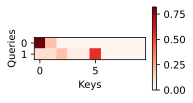

In [98]:
# Let’s check whether the attention weights actually vanish for anything beyond the second and sixth column respectively (because of setting the valid length to and ).
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')


## Testing broadcasting in matrix multiplication

bascially it will broadcast until we reach the last 2 dimensions, where it will then perform a matrix-matrix multiplication

In [100]:
x = torch.tensor(
[
  [
    [
      [1, 2],
      [3, 4]
    ]
  ],
  [
    [
      [5, 6],
      [7, 8]
    ]
  ]
])

y = torch.tensor(
[
  [
    [1, 0],
    [0, 1]
  ],
  [
    [2, 0],
    [0, 2]
  ],
  [
    [1, 1],
    [1, 1]
  ]
])


In [101]:
print(x.shape)
print(y.shape)

torch.Size([2, 1, 2, 2])
torch.Size([3, 2, 2])


In [103]:
z = torch.matmul(x, y)
z.shape

torch.Size([2, 3, 2, 2])

In [104]:
z

tensor([[[[ 1,  2],
          [ 3,  4]],

         [[ 2,  4],
          [ 6,  8]],

         [[ 3,  3],
          [ 7,  7]]],


        [[[ 5,  6],
          [ 7,  8]],

         [[10, 12],
          [14, 16]],

         [[11, 11],
          [15, 15]]]])

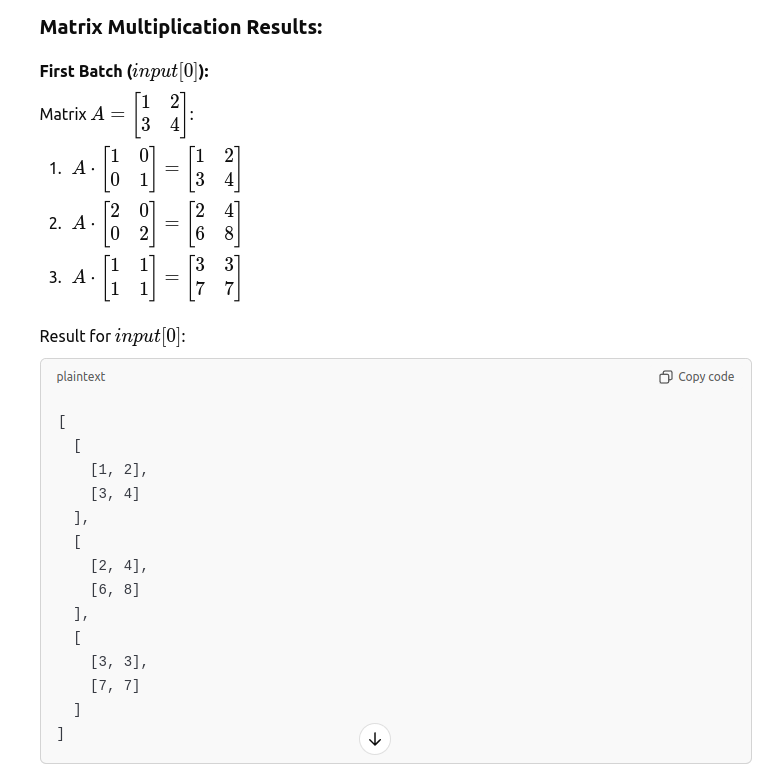

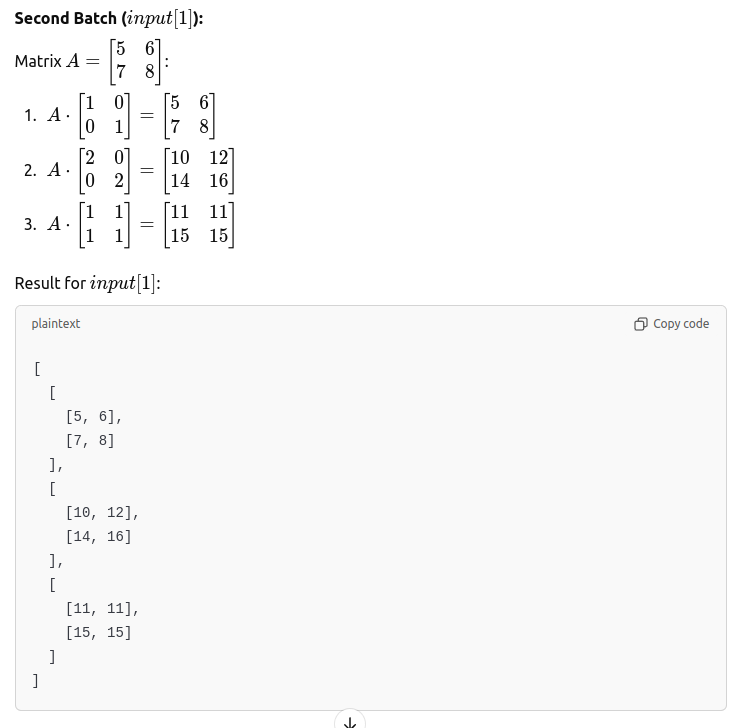


In [106]:
# Final result:

result = torch.tensor(
[
  [
    [
      [1, 2],
      [3, 4]
    ],
    [
      [2, 4],
      [6, 8]
    ],
    [
      [3, 3],
      [7, 7]
    ]
  ],
  [
    [
      [5, 6],
      [7, 8]
    ],
    [
      [10, 12],
      [14, 16]
    ],
    [
      [11, 11],
      [15, 15]
    ]
  ]
])


In [107]:
a = torch.tensor([3, 5])

tensor([3, 5])